Same as sigvar, but sigma prescription is same as reanalysis text, logsigma w [-4,-1] prior

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner

In [5]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)
names=np.array(['b0','b1','b2','b3','Te','logsig'])

In [6]:
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables
# Datos cortados
x_C,y_C=Dat[:,0][Dat[:,0]>60.0] ,Dat[:,2][Dat[:,0]>60.0] # Variables
x_C,y_C=x_C[x_C<94.0],y_C[x_C<94.0]

In [7]:
def T_b(v,b0,b1,b2,b3,Te):
  vc=75.0 # frecuancia central (rean) 
  return (b0*(v/vc)**(-2.5+b1+b2*np.log10(v/vc)))*np.exp(-b3*(v/vc)**-2.0)+Te*(1-np.exp(-b3*(v/vc)**-2.0))

In [8]:
Sol_forz=np.array([1755, -0.08 ,-0.012,0.0052,500,-1.6])

Text(0, 0.5, '$T_\\mathrm{sky}$ (K)')

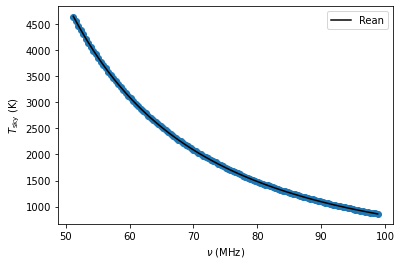

In [9]:
plt.scatter(x,y)
#plt.plot(x,T_b(x,*popt),c='y',label='MCMC')
plt.plot(x,T_b(x,*Sol_forz[:5]),c='k',label='Rean')

plt.legend()
plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$T_\mathrm{sky}$ (K)')

In [10]:
def log_like_b(theta,x,y):
  v=x
  b0,b1,b2,b3,Te,logsigma = theta
  sn2=(np.exp(logsigma))**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_b(v,b0,b1,b2,b3,Te))**2/sn2 + np.log(2*np.pi*sn2))
def log_prob_b(theta, x, y):
    lp = log_p_b(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like_b(theta, x, y)
def log_p_b(theta):
  b0,b1,b2,b3,Te,logsigma = theta
#  if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0:
  if 1600 < b0 < 1760.0 and -0.1 < b1 < -0.07 and  -0.1< b2 < 0.011 and 0.0010 <b3 < 0.2 and 200 < Te < 2000 and -4 < logsigma < -1:
#  if 1750 < a0 < 1960.0 and -260.0 < a1 < -120.0 and  -25.0< a2 < -1 and -9.5 <a3 < -7.7 and 0 < a4 < 11:

    return 0.0
  return -np.inf  

In [11]:
def nwalk_b(x,y,Sol,walkers,steps):
  N=len(Sol)  
  pos = np.array(Sol)[:,np.newaxis]+ np.array(Sol)[:,np.newaxis]*1e-3*(np.random.randn(walkers, N) ).T # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  pos=pos.T  
  nwalkers, ndim = pos.shape  

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_b, args=(x, y))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler#discard=N, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params

In [12]:
steps=10000 #pasos
walkers=500

In [13]:
Sol=Sol_forz
samples=nwalk_b(x,y,Sol,walkers,steps)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [06:52<00:00, 24.27it/s]


In [14]:
params=samples.get_chain(discard=5000, thin=100, flat=True)#parametros
params.shape

(25000, 6)

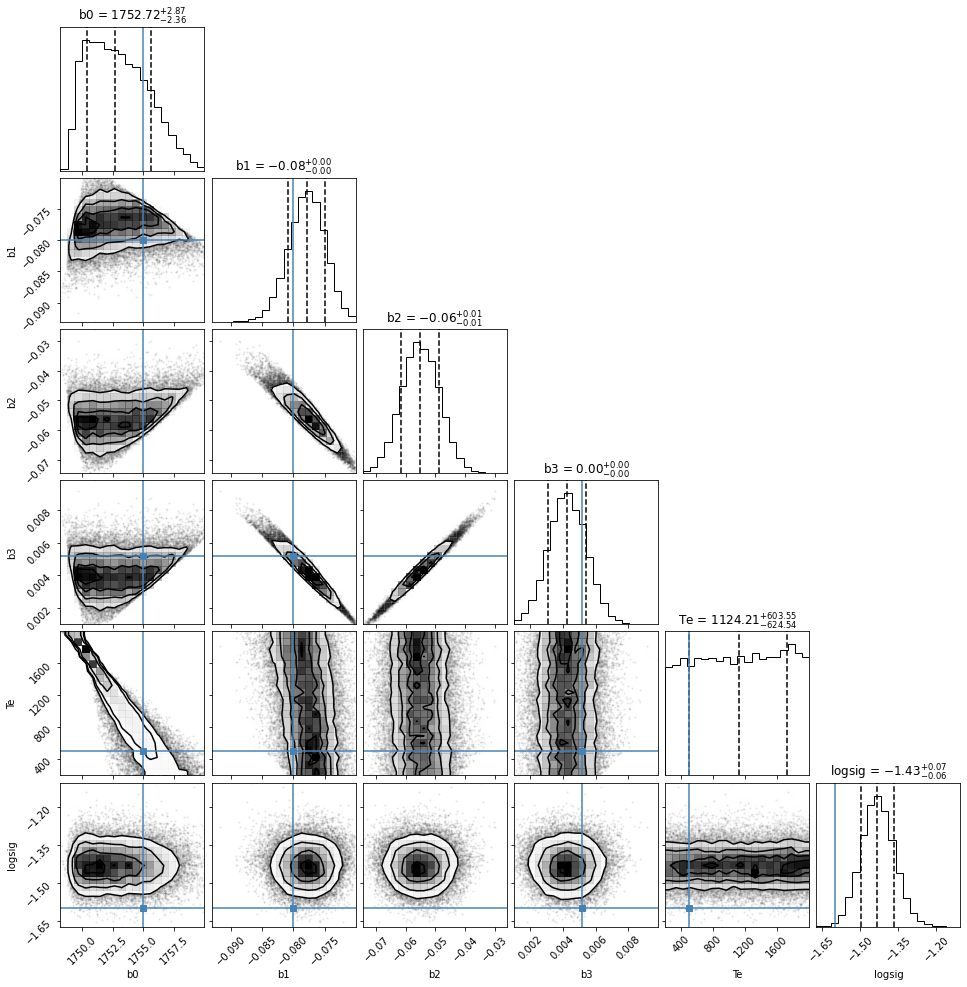

In [15]:
corner.corner(params,labels=names,quantiles=[0.16, 0.5, 0.84],truths=Sol_forz,show_titles=True)
plt.show()

In [16]:
popt=np.median(params,axis=0)

Text(0, 0.5, '$T_\\mathrm{sky}$ (K)')

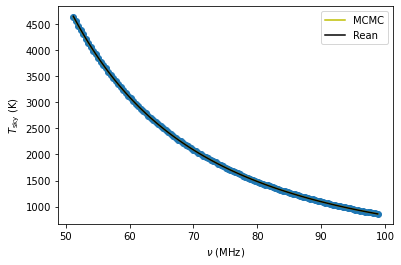

In [17]:
plt.scatter(x,y)
#plt.plot(x,T_f(x,*Sol_mpv),c='r',label='MPV')
plt.plot(x,T_b(x,*popt[:5]),c='y',label='MCMC')
plt.plot(x,T_b(x,*Sol_forz[:5]),c='k',label='Rean')

plt.legend()
plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$T_\mathrm{sky}$ (K)')

In [18]:
popt

array([ 1.75272190e+03, -7.78068278e-02, -5.52218764e-02,  4.25729956e-03,
        1.12421111e+03, -1.43171179e+00])

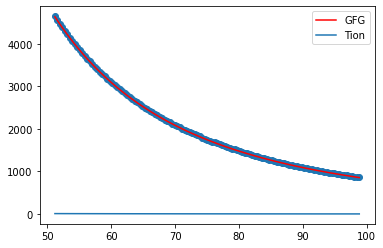

In [19]:
vc=75.0 # frecuancia central (EDGES) 
b0,b1,b2,b3,Te=popt[:5]
#popnew=np.array([ 1900.47027299,   70.13561551, -11.84228912,  -79.49207886,
#        -174.93551011])
#a0,a1,a2,a3,a4=popnew
v=x
plt.plot(x,(b0*(v/vc)**(-2.5+b1+b2*np.log10(v/vc)))*np.exp(-b3*(v/vc)**-2.0),label="GFG",c='r')
plt.plot(x,Te*(1-np.exp(-b3*(v/vc)**-2.0)),label="Tion")
#plt.plot(x,T_b(x,*popt),c='y',label='MCMC')
plt.scatter(x,y)

plt.legend()

In [20]:
Te

1124.211114509114

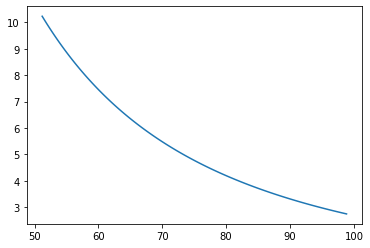

In [21]:
plt.plot(x,Te*(1-np.exp(-b3*(v/vc)**-2.0)),label="Tion")

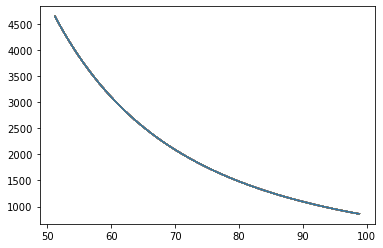

In [22]:
for i in range(100):
    plt.plot(x,T_b(x,*params[np.random.choice(len(params))][:5]),alpha=0.1)
plt.plot(x,y,lw=1)

In [23]:
selec=np.random.choice(len(params))
mu=T_b(x,*params[selec][:5])
sig=10**params[selec][5]

In [24]:
ysim=np.random.normal(mu,sig)

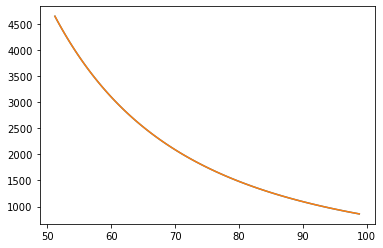

In [25]:
plt.plot(x,ysim)
plt.plot(x,y)

In [26]:
selex=np.random.choice(len(params))
yexp=T_b(x,*params[selex][:5])


In [27]:
def disc(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//10 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_b(x,*params[selec][:5])
        sig=10**params[selec][5]
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_b(x,*params[selex][:5]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
      plt.scatter(disco,discs,color='darkblue',alpha=0.4,label="Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      plt.xlim(dmin,dmax)
      plt.ylim(dmin,dmax)
      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))    
    

Rejection rate = 0 %
Bayesian p-value: 0.0


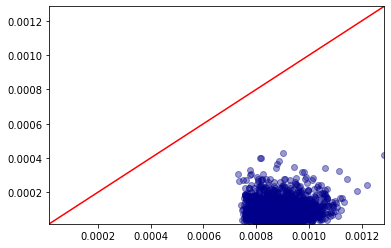

In [28]:
disc(params,x,y)